In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import math

bs_df = pd.read_excel("BS_EN_Dataset.xlsx")
#Show the 1st 5 rows of the original dataset
bs_df.head()

,Grade,Related Standard,Elongation,Yield Strength,Tensile Strength,C,Si,Mn,P,S,...,Cu,Cr,Ni,Mo,Al,Ti,V,Nb,B,Classification
0,S275N,BS ISO 630-3:2021,22,275,370-510,0-0.18,0-0.4,0.5-1.5,0-0.03,0-0.025,...,0-0.55,0-0.3,0-0.3,0-0.1,0-0.2,0-0.05,0-0.05,0-0.05,-,Non-alloy steels
1,S355N,BS ISO 630-3:2021,20,355,470-630,0-0.2,0-0.5,0.9-1.65,0-0.03,0-0.025,...,0-0.55,0-0.3,0-0.5,0-0.1,0-0.2,0-0.05,0-0.12,0-0.05,-,Non-alloy steels
2,S390N,BS ISO 630-3:2021,18,390,490-650,0-0.2,0-0.5,0.9-1.7,0-0.03,0-0.025,...,0-0.55,0-0.3,0-0.5,0-0.1,0-0.2,-,-,-,-,Non-alloy steels
3,S420N,BS ISO 630-3:2021,17,420,520-680,0-0.2,0-0.6,1-1.7,0-0.03,0-0.025,...,0-0.55,0-0.3,0-0.8,0-0.1,0-0.2,0-0.05,0-0.2,0-0.05,-,"Structural, pressure vessel and engineering st..."
4,S460N,BS ISO 630-3:2021,15,460,540-720,0-0.2,0-0.6,1-1.7,0-0.03,0-0.025,...,0-0.55,0-0.3,0-0.8,0-0.1,0-0.2,0-0.05,0-0.2,0-0.5,-,"Structural, pressure vessel and engineering st..."


In [31]:
#Split columns to min and max
def split_row(row, elem): #row = df.iloc[[i]]
    min_ = row.reset_index()[elem][0].split("-")[0]
    max_ = row.reset_index()[elem][0].split("-")[1]
    return float(min_), float(max_)

def split_dataset(df):
    for elem in df.columns[5:20]:
        df = df.assign(min_ = lambda x: 0.0)
        df = df.assign(max_ = lambda x: 0.0)
        df.rename(columns = {"min_":"min_"+elem, "max_":"max_"+elem}, inplace = True)
        for i in range(len(df)):
            try:
                min_, max_ = split_row(df.iloc[[i]], elem)
                df.at[i, "min_"+elem] = min_
                df.at[i, "max_"+elem] = max_
            except:
                continue
    return df

df_split = split_dataset(bs_df)
#Show the 1st 5 rows of the dataset after the elements are split to min and max.
df_split.head()

,Grade,Related Standard,Elongation,Yield Strength,Tensile Strength,C,Si,Mn,P,S,...,min_Al,max_Al,min_Ti,max_Ti,min_V,max_V,min_Nb,max_Nb,min_B,max_B
0,S275N,BS ISO 630-3:2021,22,275,370-510,0-0.18,0-0.4,0.5-1.5,0-0.03,0-0.025,...,0.0,0.2,0.0,0.05,0.0,0.05,0.0,0.05,0.0,0.0
1,S355N,BS ISO 630-3:2021,20,355,470-630,0-0.2,0-0.5,0.9-1.65,0-0.03,0-0.025,...,0.0,0.2,0.0,0.05,0.0,0.12,0.0,0.05,0.0,0.0
2,S390N,BS ISO 630-3:2021,18,390,490-650,0-0.2,0-0.5,0.9-1.7,0-0.03,0-0.025,...,0.0,0.2,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0
3,S420N,BS ISO 630-3:2021,17,420,520-680,0-0.2,0-0.6,1-1.7,0-0.03,0-0.025,...,0.0,0.2,0.0,0.05,0.0,0.20,0.0,0.05,0.0,0.0
4,S460N,BS ISO 630-3:2021,15,460,540-720,0-0.2,0-0.6,1-1.7,0-0.03,0-0.025,...,0.0,0.2,0.0,0.05,0.0,0.20,0.0,0.50,0.0,0.0


In [32]:
#Create expanded dataset
#Functions to expand rows
#yield or tensile is a range
def expand_row(row, feature, k): #row = df.iloc[[i]], i = 0:139
    feat_range = row.reset_index()[feature][0].split("-")
    feat_range = list(np.linspace(int(feat_range[0]), int(feat_range[1]), k))
    feat_range = [int(i) for i in feat_range]
    for i in range(k-1):
        row = row.append(row.iloc[[0]])
    row[feature] = feat_range
    return row

#yield and tensile are ranges
def expand_row_2(row, k):
    yield_range = row.reset_index()["Yield Strength"][0].split("-")
    mean_yield = int((int(yield_range[0]) + int(yield_range[1])) / 2)
    row = row.reset_index()
    row.at[0, "Yield Strength"] = mean_yield
    return expand_row(row, "Tensile Strength", k)

#yield and tensile are not ranges
def expand_row_3(row, k):
    feat_range = list(np.linspace(row["Tensile Strength"] - 4, row["Tensile Strength"] + 5, k))
    feat_range = [int(i) for i in feat_range]
    for i in range(k-1):
        row = row.append(row.iloc[[0]])
    row["Tensile Strength"] = feat_range
    return row

#Create expanded dataset
def expand_df(df, k):
    df2 = pd.DataFrame(columns=list(df.columns))
    for i in range(len(df)):
        row = df.iloc[[i]]
        if type(row.reset_index()["Tensile Strength"][0]) == str and type(row.reset_index()["Yield Strength"][0]) != str:
            expanded_row = expand_row(row, "Tensile Strength", k)
        elif type(row.reset_index()["Yield Strength"][0]) == str and type(row.reset_index()["Tensile Strength"][0]) != str:
            expanded_row = expand_row(row, "Yield Strength", k)
        elif type(row.reset_index()["Yield Strength"][0]) == str and type(row.reset_index()["Tensile Strength"][0]) == str:
            expanded_row = expand_row_2(row, k)
        elif type(row.reset_index()["Yield Strength"][0]) != str and type(row.reset_index()["Tensile Strength"][0]) != str:
            expanded_row = expand_row_3(row, k)
        df2 = pd.concat([df2, expanded_row], ignore_index=True)
    return df2

df2 = expand_df(df_split, 76)
#Show the 1st 5 rows of the dataset after the tensile properties are expanded
df2.head()

,Grade,Related Standard,Elongation,Yield Strength,Tensile Strength,C,Si,Mn,P,S,...,max_Al,min_Ti,max_Ti,min_V,max_V,min_Nb,max_Nb,min_B,max_B,index
0,S275N,BS ISO 630-3:2021,22,275,370,0-0.18,0-0.4,0.5-1.5,0-0.03,0-0.025,...,0.2,0.0,0.05,0.0,0.05,0.0,0.05,0.0,0.0,NaN
1,S275N,BS ISO 630-3:2021,22,275,371,0-0.18,0-0.4,0.5-1.5,0-0.03,0-0.025,...,0.2,0.0,0.05,0.0,0.05,0.0,0.05,0.0,0.0,NaN
2,S275N,BS ISO 630-3:2021,22,275,373,0-0.18,0-0.4,0.5-1.5,0-0.03,0-0.025,...,0.2,0.0,0.05,0.0,0.05,0.0,0.05,0.0,0.0,NaN
3,S275N,BS ISO 630-3:2021,22,275,375,0-0.18,0-0.4,0.5-1.5,0-0.03,0-0.025,...,0.2,0.0,0.05,0.0,0.05,0.0,0.05,0.0,0.0,NaN
4,S275N,BS ISO 630-3:2021,22,275,377,0-0.18,0-0.4,0.5-1.5,0-0.03,0-0.025,...,0.2,0.0,0.05,0.0,0.05,0.0,0.05,0.0,0.0,NaN


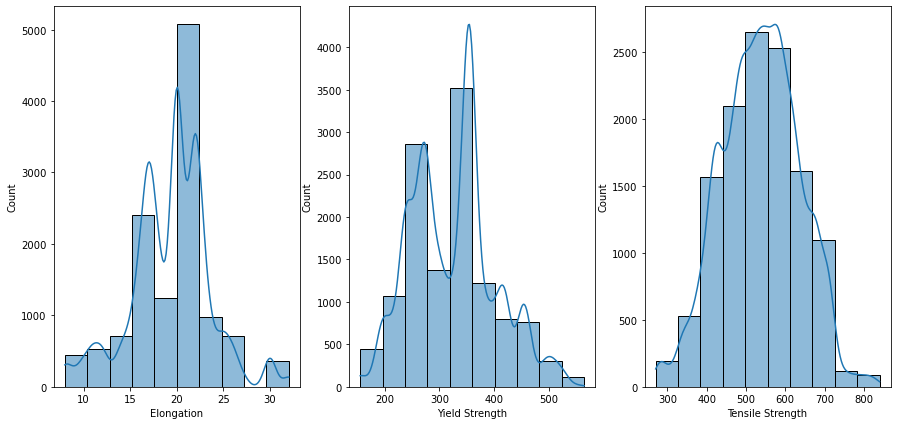

In [16]:
### Visualize the elongation, yield strength, and tensile strength data

##Using a histogram
#create the figure and axis
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))
# assigning a graph to each ax
sns.histplot( df2["Elongation"], kde=True, ax=ax1, bins = 10)
sns.histplot( data=df2["Yield Strength"], kde=True, ax=ax2, bins = 10)
sns.histplot( data=df2["Tensile Strength"], kde=True, ax=ax3, bins = 10)
 
plt.show()
plt.close()

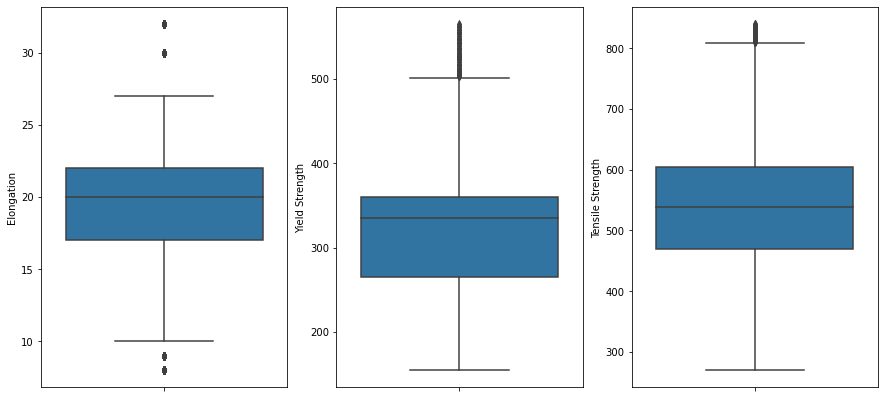

In [17]:
##Better visualize the input data using boxplots that show: mean, interquartile range, and outliers.

#create the figure and axis
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7))

# assigning a graph to each ax
sns.boxplot( y=df2["Elongation"], ax=ax1 )
sns.boxplot( y=df2["Yield Strength"], ax=ax2 )
sns.boxplot( y=df2["Tensile Strength"], ax=ax3 )
plt.show()

In [4]:
###Prepare the data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#change data types to integers
df2 = df2.astype({"Elongation": int, "Yield Strength": int, "Tensile Strength": int})


#normalize input data (elongation, yield strength, tensile strength)
def normalize_data(df):
    df_min_max_scaled = df.copy()
    for column in df_min_max_scaled.columns[2:5]:
        df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())
    x = df_min_max_scaled[df_min_max_scaled.columns[2:5]].values.tolist()
    return x #list

    
#split the data to training and testing samples
def split_data(output, df=df2):
    x = normalize_data(df)
    y = df[output].values.tolist()
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=3)
    return x_train, x_test, y_train, y_test #all lists


#normalize a new datapoint
def normalize_point(point):
    df_slice = df2[df2.columns[2:5]]
    for i in range(len(df_slice.columns)):
        point[i] = (point[i] - df_slice[df_slice.columns[i]].min()) / (df_slice[df_slice.columns[i]].max() - df_slice[df_slice.columns[i]].min())
    return np.array([point])

In [5]:
#Statistics for the dataset's features
df2.describe()

,Elongation,Yield Strength,Tensile Strength,min_C,max_C,min_Si,max_Si,min_Mn,max_Mn,min_P,...,max_Al,min_Ti,max_Ti,min_V,max_V,min_Nb,max_Nb,min_B,max_B,index
count,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.0,...,10640.000000,10640.0,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,10640.000000,152.000000
mean,19.350000,325.600752,537.382989,0.079571,0.225286,0.013214,0.417500,0.522857,1.232500,0.0,...,0.025679,0.0,0.018857,0.001143,0.044286,0.000107,0.024571,0.000014,0.000086,106.000000
std,4.232599,77.093987,99.026759,0.153750,0.127881,0.039012,0.149879,0.441462,0.491774,0.0,...,0.059609,0.0,0.028477,0.009494,0.062683,0.001263,0.048263,0.000168,0.000541,15.049587
min,8.000000,155.000000,270.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.000000
25%,17.000000,265.000000,469.000000,0.000000,0.167500,0.000000,0.350000,0.000000,0.875000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.000000
50%,20.000000,335.000000,540.000000,0.000000,0.200000,0.000000,0.400000,0.500000,1.400000,0.0,...,0.007500,0.0,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,106.000000
75%,22.000000,360.000000,606.000000,0.105000,0.220000,0.000000,0.500000,0.912500,1.650000,0.0,...,0.020000,0.0,0.030000,0.000000,0.060000,0.000000,0.050000,0.000000,0.000000,121.000000
max,32.000000,565.000000,840.000000,0.570000,0.650000,0.150000,0.600000,1.400000,1.800000,0.0,...,0.550000,0.0,0.150000,0.080000,0.200000,0.015000,0.500000,0.002000,0.006000,121.000000


In [6]:
###KNN regression

#A function to deal with outliers in certein elements for KNN regression
def improve_elems_KNN(scores):
    #Improve max_Al
    max_Al_no_outliers = df2[(df2["max_Al"] != 0.550) & (df2["max_Al"] != 0.200)]
    x_train, x_test, y_train, y_test = split_data("max_Al", max_Al_no_outliers)
    reg = KNeighborsRegressor(n_neighbors=10)
    reg.fit(x_train, y_train)
    scores["max_Al"] = reg.score(x_test, y_test)

    #Improve min_Si
    min_si_no_outliers = df2[df2["min_Si"] != 0.15]
    x_train, x_test, y_train, y_test = split_data("min_Si", min_si_no_outliers)
    reg = KNeighborsRegressor(n_neighbors=10)
    reg.fit(x_train, y_train)
    scores["min_Si"] = reg.score(x_test, y_test)

    #Imrove min_Nb
    min_nb_no_outliers = df2[df2["min_Nb"] != 0.015]
    x_train, x_test, y_train, y_test = split_data("min_Nb", min_nb_no_outliers)
    reg = KNeighborsRegressor(n_neighbors=10)
    reg.fit(x_train, y_train)
    scores["min_Nb"] = reg.score(x_test, y_test)

    #Improve max_N
    max_N_no_outliers = df2[(df2["max_N"] != 12.000) & (df2["max_N"] != 0.300)]
    x_train, x_test, y_train, y_test = split_data("max_N", max_N_no_outliers)
    reg = KNeighborsRegressor(n_neighbors=10)
    reg.fit(x_train, y_train)
    scores["max_N"] = reg.score(x_test, y_test)

    #Improve max_Nb
    max_Nb_no_outliers = df2[df2["max_Nb"] != 0.50]
    x_train, x_test, y_train, y_test = split_data("max_Nb", max_Nb_no_outliers)
    reg = KNeighborsRegressor(n_neighbors=10)
    reg.fit(x_train, y_train)
    scores["max_Nb"] = reg.score(x_test, y_test)
    
    return scores

In [7]:
##Train KNN regression model
from sklearn.neighbors import KNeighborsRegressor

#train the KNN model
def run_model_KNN_reg(n):
    scores = {}
    for elem in df2.columns[21:-1]:
        x_train, x_test, y_train, y_test = split_data(elem, df2)
        reg = KNeighborsRegressor(n_neighbors=n)
        reg.fit(x_train, y_train)
        scores[elem] = reg.score(x_test, y_test)
    scores = improve_elems_KNN(scores)
    average_score_KNN = sum(scores.values())/len(scores)
    return scores, average_score_KNN

#predict the chemical content of a new datapoint using KNN
def test_point_KNN(point, n,  df = df2):
    norm_point = normalize_point(point)
    average_score = 0
    for elem in list(df2.columns)[21:-1]:
        x_train, x_test, y_train, y_test = split_data("min_"+elem)
        reg = KNeighborsRegressor(n_neighbors=n)
        reg.fit(x_train, y_train)
        pred = reg.predict(norm_point)
        print("Model prediction for "+elem+": {:.2f}".format(pred[0]))

#Run the KNN model and print the accuracy
scores, avg_score_KNN = run_model_KNN_reg(10)
print("The average r^2 score for KNN regression: {:.3f}".format(avg_score_KNN))

The average r^2 score for KNN regression: 0.902


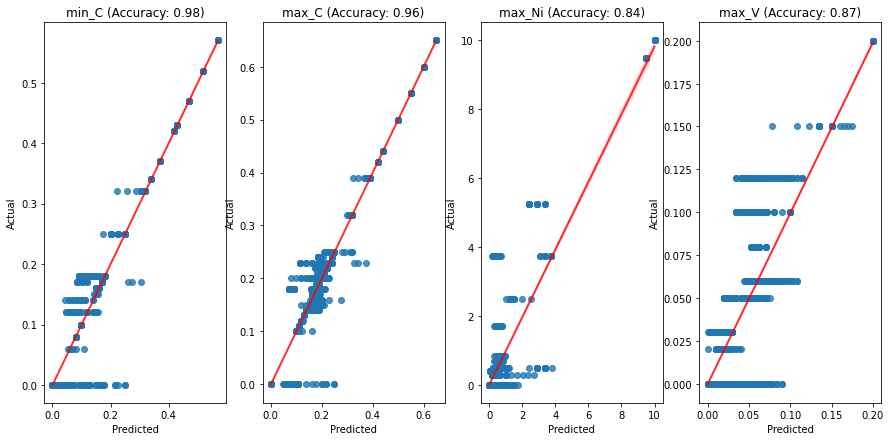

In [74]:
##Visualize KNN regression performance on example elements

#Elemes to plot their performance
example_elems = ['min_C','max_C','max_Ni','max_V']

#Scatter plot of predicted vs actual output for example elements
#Create figure and axes
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 7))
axes = [ax1, ax2, ax3, ax4]

#Plot prediction vs actual for each element
for i in range(len(example_elems)):
    x_train, x_test, y_train, y_test = split_data(example_elems[i])
    reg = KNeighborsRegressor(n_neighbors=10)
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    
    sns.regplot(x=y_pred, y=y_test, line_kws={"color":"r","alpha":0.8,"lw":2}, ax=axes[i]).set(
        title=example_elems[i]+" (Accuracy: {:.2f})".format(reg.score(x_test, y_test)), xlabel='Predicted', ylabel='Actual')
plt.show()
plt.close()

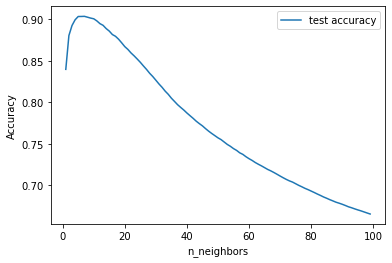

In [21]:
##Visualize the effect of hyperparameters
#The effect of "k-neighbours" on KNN regression
test_accuracy = []
neighbors_settings = range(1, 100)

for n_neighbors in neighbors_settings:
    scores, avg_score_KNN = run_model_KNN_reg(n_neighbors)
    test_accuracy.append(avg_score_KNN)

    
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [8]:
##Visualize the effect of expansion-value (k) on KNN average accuracy
k_values = list(range(7, 90))
average_scores = []
for k in k_values:
    df2 = expand_df(df_split, k)
    scores, average_score_KNN = run_model_KNN_reg(10)
    average_scores.append(average_score_KNN)

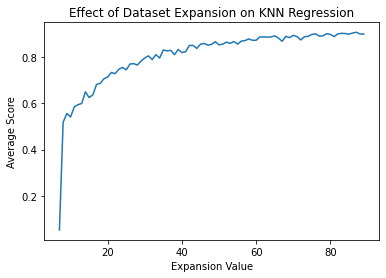

In [9]:
plt.plot(k_values, average_scores)
plt.ylabel("Average Score")
plt.xlabel("Expansion Value")
plt.title("Effect of Dataset Expansion on KNN Regression")
plt.show()
plt.close()

In [75]:
##Function to determine the steel grade using its predicted chemical contents.
##It'll go through every grade, calculate the error for each element, and pick the grade with least error.

#Find grade using KNN regression. Takes a while to run (~15 mins)
def find_grade_KNN(point, n):
    norm_point = normalize_point(point)
    error_dict = dict(zip(bs_df["Grade"].values.tolist(), [1000]*len(bs_df["Grade"].values.tolist())))
    elem_cols = list(df2.columns)[21:-1]
    knn_regs = [0]*len(elem_cols)
    for i in range(len(elem_cols)):
        reg1 = build_KNN(n, elem_cols[i])
        knn_regs[i] = reg1
    #loop through every row
    for i in range(len(df2)):
        grade_err = 0
        #for each row/grade, loop through every element find and add error 
        for j in range(len(elem_cols)):
            reg = knn_regs[j]
            point_pred = reg.predict(norm_point)
            elem_err = (df2.iloc[[i]].reset_index()[elem_cols[j]][0] - point_pred[0]) ** 2
            grade_err += elem_err
        if grade_err < error_dict[df2["Grade"].iloc[i]]:
            error_dict[df2["Grade"].iloc[i]] = grade_err
    res = {key:val for key,val in error_dict.items() if val == min(error_dict.values())}
    print("The grade as predicted by KNN is : " + str(list(res.keys())[0:4]))
    return error_dict

#function to create KNN model for an output (used in previous function)
def build_KNN(n, output):
    x_train, x_test, y_train, y_test = split_data(output)
    reg = KNeighborsRegressor(n_neighbors=n)
    reg.fit(x_train, y_train)
    return reg

In [11]:
###Polynomial regression

#A function to deal with outliers in certein elements for polynomial regression
def improve_elems_poly(scores):
    #Improve max_Al
    max_Al_no_outliers = df2[(df2["max_Al"] != 0.550) & (df2["max_Al"] != 0.200)]
    x_train, x_test, y_train, y_test = split_data("max_Al", max_Al_no_outliers)
    poly = PolynomialFeatures(degree=13, include_bias=False)
    poly = PolynomialFeatures(degree=13, include_bias=False)
    poly_features = poly.fit_transform(np.array(x_train))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, np.array(y_train))
    y_pred = poly_reg_model.predict(poly_features)
    scores["max_Al"] = r2_score(y_train, y_pred)

    #Improve min_Si
    min_si_no_outliers = df2[df2["min_Si"] != 0.15]
    x_train, x_test, y_train, y_test = split_data("min_Si", min_si_no_outliers)
    poly = PolynomialFeatures(degree=13, include_bias=False)
    poly_features = poly.fit_transform(np.array(x_train))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, np.array(y_train))
    y_pred = poly_reg_model.predict(poly_features)
    scores["min_Si"] = r2_score(y_train, y_pred)

    #Imrove min_Nb
    min_nb_no_outliers = df2[df2["min_Nb"] != 0.015]
    x_train, x_test, y_train, y_test = split_data("min_Nb", min_nb_no_outliers)
    poly = PolynomialFeatures(degree=13, include_bias=False)
    poly = PolynomialFeatures(degree=13, include_bias=False)
    poly_features = poly.fit_transform(np.array(x_train))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, np.array(y_train))
    y_pred = poly_reg_model.predict(poly_features)
    scores["min_Nb"] = r2_score(y_train, y_pred)

    #Improve max_N
    max_N_no_outliers = df2[(df2["max_N"] != 12.000) & (df2["max_N"] != 0.300)]
    x_train, x_test, y_train, y_test = split_data("max_N", max_N_no_outliers)
    poly = PolynomialFeatures(degree=13, include_bias=False)
    poly_features = poly.fit_transform(np.array(x_train))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, np.array(y_train))
    y_pred = poly_reg_model.predict(poly_features)
    scores["max_N"] = r2_score(y_train, y_pred)

    #Improve max_Nb
    max_Nb_no_outliers = df2[df2["max_Nb"] != 0.50]
    x_train, x_test, y_train, y_test = split_data("max_Nb", max_Nb_no_outliers)
    poly = PolynomialFeatures(degree=13, include_bias=False)
    poly_features = poly.fit_transform(np.array(x_train))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, np.array(y_train))
    y_pred = poly_reg_model.predict(poly_features)
    scores["max_Nb"] = r2_score(y_train, y_pred)
    
    return scores

In [12]:
##Train polynomial regression model
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

#train the model
def run_model_poly_reg(n):
    scores = {}
    for elem in df2.columns[21:-1]:        
        x_train, x_test, y_train, y_test = split_data(elem)
        poly = PolynomialFeatures(degree=n, include_bias=False)
        poly_features = poly.fit_transform(np.array(x_train))
        poly_reg_model = LinearRegression()
        poly_reg_model.fit(poly_features, np.array(y_train))
        y_pred = poly_reg_model.predict(poly_features)
        scores[elem] = r2_score(y_train, y_pred)
    scores = improve_elems_poly(scores)
    average_score_poly = sum(scores.values())/len(scores)
    return scores, average_score_poly

#predict the chemical content of a new datapoint using KNN
def test_point_poly(point, df, n):
    norm_point = normalize_point(point, df[df.columns[2:5]])
    average_score = 0
    for elem in list(df.columns)[5:]:
        x_train, x_test, y_train, y_test = split_data("min_"+elem)
        poly = PolynomialFeatures(degree=n, include_bias=False)
        poly_features = poly.fit_transform(np.array(x_train))
        poly_reg_model = LinearRegression()
        poly_reg_model.fit(poly_features, np.array(y_train))
        min_ = reg.predict(norm_point)
        
        x_train, x_test, y_train, y_test = split_data("max_"+elem)
        poly = PolynomialFeatures(degree=n, include_bias=False)
        poly_features = poly.fit_transform(np.array(x_train))
        poly_reg_model = LinearRegression()
        poly_reg_model.fit(poly_features, np.array(y_train))
        max_ = reg.predict(norm_point)
        
        print("Model prediction for "+elem+": [{:.2f}, {:.2f}]".format(min_[0], max_[0]))

#Run the model and print the average accuracy accross all elements
scores, average_score_poly = run_model_poly_reg(11)
print("The average r^2 score for polynomial regression: {:.3f}".format(average_score_poly))

The average r^2 score for polynomial regression: 0.861


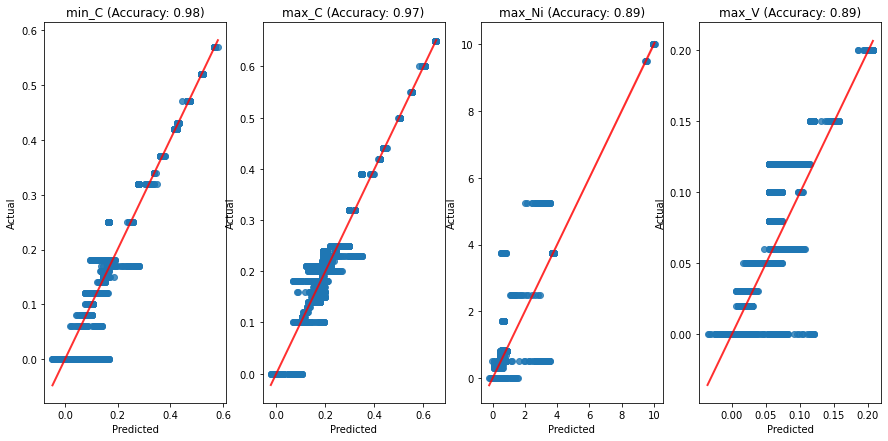

In [20]:
##Visualize polynomial regression performance on example elements

#Elements to plot their performance
example_elems = ['min_C','max_C','max_Ni','max_V']

#Scatter plot of predicted vs actual output for example elements
#Create figure and axes
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 7))
axes = [ax1, ax2, ax3, ax4]

#Plot prediction vs actual for each element
for i in range(len(example_elems)):
    x_train, x_test, y_train, y_test = split_data(example_elems[i])
    poly = PolynomialFeatures(degree=13, include_bias=False)
    poly_features = poly.fit_transform(np.array(x_train))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, np.array(y_train))
    y_pred = poly_reg_model.predict(poly_features)

    sns.regplot(x=y_pred, y=y_train, line_kws={"color":"r","alpha":0.8,"lw":2}, ax=axes[i]).set(
        title=example_elems[i]+" (Accuracy: {:.2f})".format(r2_score(y_train, y_pred)), xlabel='Predicted', ylabel='Actual')
plt.show()
plt.close()

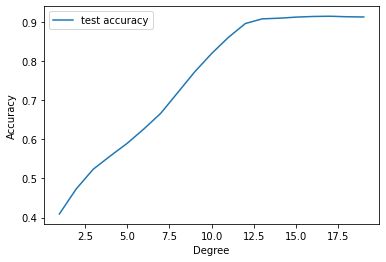

In [22]:
##Visualize the effect of hyperparameters
#The effect of the polynomial's degree on accuracy

test_accuracy = []
degree_settings = range(1, 20)

for degree in degree_settings:
    scores, average_score_poly = run_model_poly_reg(degree)
    test_accuracy.append(average_score_poly)

    
plt.plot(degree_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Degree")
plt.legend()

In [13]:
##Visualize the effect of expansion-value (k) on polynomial-regression average accuracy
k_values = list(range(7, 90))
average_scores = []
for k in k_values:
    df2 = expand_df(df_split, k)
    scores, average_score_poly = run_model_poly_reg(13)
    average_scores.append(average_score_poly)

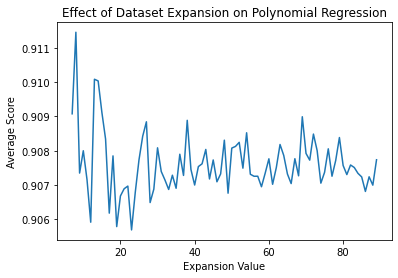

In [14]:
plt.plot(k_values, average_scores)
plt.ylabel("Average Score")
plt.xlabel("Expansion Value")
plt.title("Effect of Dataset Expansion on Polynomial Regression")
plt.show()
plt.close()

In [76]:
#Find grade using polynomial regression. It takes a while to run (~15 mins)
def find_grade_poly(point, n):
    norm_point = normalize_point(point)
    error_dict = dict(zip(bs_df["Grade"].values.tolist(), [1000]*len(bs_df["Grade"].values.tolist())))
    elem_cols = list(df2.columns)[21:-1]
    poly_regs = [0]*len(elem_cols)
    for i in range(len(elem_cols)):
        reg1 = build_poly(n, elem_cols[i])
        poly_regs[i] = reg1
    #loop through every row
    for i in range(len(df2)):
        grade_err = 0
        print("\nRow: {}".format(i))
        #for each row/grade, loop through every element find and add error 
        for j in range(len(elem_cols)):
            reg = poly_regs[j]
            point_pred = poly_reg_model.predict(poly.fit_transform(norm_point))
            elem_err = (df2.iloc[[i]].reset_index()[elem_cols[j]][0] - point_pred[0]) ** 2
            grade_err += elem_err
        if grade_err < error_dict[df2["Grade"].iloc[i]]:
            error_dict[df2["Grade"].iloc[i]] = grade_err
    res = {key:val for key,val in error_dict.items() if val == min(error_dict.values())}
    print("The grade as predicted by polynomial regression is : " + str(list(res.keys())[0:4]))
    return error_dict

#function to create polynomial-regression model for an output (used in previous function)
def build_poly(n, output):
    x_train, x_test, y_train, y_test = split_data(output)
    poly = PolynomialFeatures(degree=12, include_bias=False)
    poly_features = poly.fit_transform(np.array(x_train))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, np.array(y_train))
    return poly_reg_model